#  BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation
Vision-Language Pre-training (VLP) has advanced the performance for many vision-language tasks. However, most existing pre-trained models only excel in either understanding-based tasks or generation-based tasks. Furthermore, performance improvement has been largely achieved by scaling up the dataset with noisy image-text pairs collected from the web, which is a suboptimal source of supervision. In this paper, we propose BLIP, a new VLP framework which transfers flexibly to both vision-language understanding and generation tasks. BLIP effectively utilizes the noisy web data by bootstrapping the captions, where a captioner generates synthetic captions and a filter removes the noisy ones. We achieve state-of-the-art results on a wide range of vision-language tasks, such as image-text retrieval (+2.7% in average recall@1), image captioning (+2.8% in CIDEr), and VQA (+1.6% in VQA score). BLIP also demonstrates strong generalization ability when directly transferred to videolanguage tasks in a zero-shot manner. Code, models, and datasets are released.

# Radiology Objects in COntext (ROCO): A Multimodal Image Dataset
Radiology Objects in COntext (ROCO) dataset, a large-scale medical and multimodal imaging dataset. The listed images are from publications available on the PubMed Central Open Access FTP mirror, which were automatically detected as non-compound and either radiology or non-radiology. Each image is distributed as a download link, together with its caption. Additionally, keywords extracted from the image caption, as well as the corresponding UMLS Semantic Types (SemTypes) and UMLS Concept Unique Identifiers (CUIs) are available. The dataset could be used to build generative models for image captioning, classification models for image categorization and tagging or content-based image retrieval systems.


# Caption Generation from Chest X-Ray Images:
![](https://i.ibb.co/G9bd0bg/chest-Xray.png)



Task : Fine tune Captioning model with a custom dataset using the following transformers to generate description of a chest x-ray image.
Base Model: The base transformers models to be used for fine tuning :

Salesforce/blip-image-captioning-large

Dataset : Radiology Objects in COntext (ROCO): A Multimodal Image Dataset


## Installation and Dataloader

In [1]:
# Install latest version of the library
!pip install -q datasets==2.13.1 nltk

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.4 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 16.1.0 which is incompatible.
pathos 0.3.3 requires dill>=0.3.9, but you have dill 0.3.6 which is incompatible.
pathos 0.3.3 requires multiprocess>=0.70.17, but you have multiprocess 0.70.14 which is incompatible.


In [2]:
# Import important libraries
import pandas as pd
from datasets import load_dataset
import transformers
from transformers import BlipProcessor, BlipForImageTextRetrieval,BlipForConditionalGeneration, AutoProcessor
import torch
from torch.utils.data import Dataset, DataLoader,random_split
from torchvision.transforms import Resize
import os

import gc
import numpy as np
import pandas as pd
import itertools
from tqdm import tqdm
import albumentations as A
import cv2
import shutil
import json
from PIL import Image
import requests
from matplotlib import pyplot as plt
from nltk.translate.bleu_score import sentence_bleu

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Read CSV dataset from Pandas
df_train = pd.read_csv('/kaggle/input/roco-dataset/all_data/train/radiologytraindata.csv', delimiter=',') #, nrows = nRowsRead
df_val = pd.read_csv('/kaggle/input/roco-dataset/all_data/validation/radiology/valdata.csv', delimiter=',') #, nrows = nRowsRead

In [4]:
# Display first 5 columns of dataframe
df_train.head()


id                                    name  \
0  ROCO_00002          PMC4083729_AMHSR-4-14-g002.jpg   
1  ROCO_00003       PMC2837471_IJD2009-150251.001.jpg   
2  ROCO_00004  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3  ROCO_00005       PMC3745845_IJD2013-683423.005.jpg   
4  ROCO_00007   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  
0   Computed tomography scan in axial view showin...  
1   Bacterial contamination occurred after comple...  
2   The patient had residual paralysis of the han...  
3    Panoramic radiograph after immediate loading.\n  
4   Plain abdomen x-ray: Multiple air levels at t...

In [5]:
df_val.head()

id                                    name  \
0  ROCO_00020    PMC3970251_CRIONM2014-931546.003.jpg   
1  ROCO_00027          PMC2766744_cios-1-176-g005.jpg   
2  ROCO_00059  PMC3789931_poljradiol-78-3-35-g001.jpg   
3  ROCO_00062               PMC2676075_p147_fig4a.jpg   
4  ROCO_00068    PMC5292123_CRIGM2017-1710501.002.jpg   

                                             caption  
0   Axial computed tomography scan of the pelvis ...  
1   Postoperative anteroposterior radiograph of t...  
2   Angiography of the internal carotid artery, l...  
3   Case 4: (A) pretreatment radiograph; (B) Root...  
4   Preintervention MRCP revealing a nine-millime...

In [6]:
df_train.shape

(65450, 3)

In [7]:
df_val.shape

(8180, 3)

In [8]:
#Create "images" column to create full path for images
df_train['images'] = "/kaggle/input/roco-dataset/all_data/train/radiology/images/" + df_train['name']
df_train.head()

id                                    name  \
0  ROCO_00002          PMC4083729_AMHSR-4-14-g002.jpg   
1  ROCO_00003       PMC2837471_IJD2009-150251.001.jpg   
2  ROCO_00004  PMC2505281_11999_2007_30_Fig6_HTML.jpg   
3  ROCO_00005       PMC3745845_IJD2013-683423.005.jpg   
4  ROCO_00007   PMC4917066_amjcaserep-17-301-g001.jpg   

                                             caption  \
0   Computed tomography scan in axial view showin...   
1   Bacterial contamination occurred after comple...   
2   The patient had residual paralysis of the han...   
3    Panoramic radiograph after immediate loading.\n   
4   Plain abdomen x-ray: Multiple air levels at t...   

                                              images  
0  /kaggle/input/roco-dataset/all_data/train/radi...  
1  /kaggle/input/roco-dataset/all_data/train/radi...  
2  /kaggle/input/roco-dataset/all_data/train/radi...  
3  /kaggle/input/roco-dataset/all_data/train/radi...  
4  /kaggle/input/roco-dataset/all_data/train/radi...

In [9]:
#Create "images" column to create full path for images
df_val['images'] = "/kaggle/input/roco-dataset/all_data/validation/radiology/images/" + df_val['name']
df_val.head()

id                                    name  \
0  ROCO_00020    PMC3970251_CRIONM2014-931546.003.jpg   
1  ROCO_00027          PMC2766744_cios-1-176-g005.jpg   
2  ROCO_00059  PMC3789931_poljradiol-78-3-35-g001.jpg   
3  ROCO_00062               PMC2676075_p147_fig4a.jpg   
4  ROCO_00068    PMC5292123_CRIGM2017-1710501.002.jpg   

                                             caption  \
0   Axial computed tomography scan of the pelvis ...   
1   Postoperative anteroposterior radiograph of t...   
2   Angiography of the internal carotid artery, l...   
3   Case 4: (A) pretreatment radiograph; (B) Root...   
4   Preintervention MRCP revealing a nine-millime...   

                                              images  
0  /kaggle/input/roco-dataset/all_data/validation...  
1  /kaggle/input/roco-dataset/all_data/validation...  
2  /kaggle/input/roco-dataset/all_data/validation...  
3  /kaggle/input/roco-dataset/all_data/validation...  
4  /kaggle/input/roco-dataset/all_data/validation...

In [10]:
import os
from PIL import Image

# Function to check if a file exists and if it can be opened by PIL.Image, then remove rows with missing or invalid files
def check_and_remove_missing_or_invalid_files(df, column_name):
    missing_or_invalid_files = []

    # Check for missing files or invalid images
    for idx, image_path in df[column_name].items():
        if not os.path.isfile(image_path):
            missing_or_invalid_files.append(idx)
        else:
            try:
                # Try opening the image to check for validity
                img = Image.open(image_path)
                img.verify()  # Verify that it is, indeed, an image
            except Exception as e:  # Catch all exceptions
                print(f"Error with file {image_path}: {e}")
                missing_or_invalid_files.append(idx)

    # Remove rows with missing or invalid files
    if missing_or_invalid_files:
        print(f"Removing {len(missing_or_invalid_files)} rows with missing or invalid files.")
        df = df.drop(missing_or_invalid_files).reset_index(drop=True)  # Reset index after dropping rows
    else:
        print("All files are present and valid!")

    return df


In [11]:
# Assuming the 'images' column contains the full image paths
df_train = check_and_remove_missing_or_invalid_files(df_train, 'images')

# Check the DataFrame after removal
df_train.shape

Error with file /kaggle/input/roco-dataset/all_data/train/radiology/images/PMC4240561_MA-68-291-g002.jpg: cannot identify image file '/kaggle/input/roco-dataset/all_data/train/radiology/images/PMC4240561_MA-68-291-g002.jpg'
Removing 31 rows with missing or invalid files.


(65419, 4)

In [12]:
df_val = check_and_remove_missing_or_invalid_files(df_val,'images')

df_val.shape

Removing 5 rows with missing or invalid files.


(8175, 4)

In [13]:
from PIL import Image
#Create class for training
class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor, image_size=(224, 224)):
        self.dataset = dataset
        self.processor = processor
        self.image_size = image_size
        self.resize_transform = Resize(image_size)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset.iloc[idx]
        img = Image.open(item['images'])
        encoding = self.processor(images=img, text=item["caption"], padding="max_length",truncation=True , return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [14]:
# Load model from Huggingface Transformer library
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [15]:
# Create dataset for training
image_size = (224, 224)
train_dataset = ImageCaptioningDataset(df_train, processor, image_size)
val_dataset = ImageCaptioningDataset(df_val, processor, image_size)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)
val_dataloader = DataLoader(val_dataset, batch_size=2)

In [16]:
train_dataloader

In [17]:
val_dataloader

In [18]:
# initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()

BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [19]:
from tqdm import tqdm
from PIL import UnidentifiedImageError

# Function to save checkpoints
def save_checkpoint(model, optimizer, epoch, loss, checkpoint_dir="checkpoints"):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Function to load from checkpoint
def load_checkpoint(model, optimizer, checkpoint_path):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(f"Loaded checkpoint from epoch {epoch} with loss {loss}")
        return epoch + 1  # Start from the next epoch
    else:
        print(f"No checkpoint found at {checkpoint_path}")
        return 0  # Start from scratch if no checkpoint is found

# Training and evaluation loop with checkpointing
start_epoch = load_checkpoint(model, optimizer, "checkpoints/checkpoint_epoch_2.pt")  # Adjust path as needed
num_epochs = 3

for epoch in range(start_epoch, num_epochs):
    print(f"Epoch: {epoch}")

    # Training phase
    model.train()
    for idx, batch in enumerate(tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}")):
        if batch is None:  # Skip corrupted batches
            continue
        
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        
        # Backpropagation
        loss.backward()
        
        # Optimization step
        optimizer.step()
        optimizer.zero_grad()

    print(f"Training Loss after Epoch {epoch+1}: {loss.item()}")

    # Save checkpoint after each epoch
    save_checkpoint(model, optimizer, epoch, loss.item())

    # Evaluation phase
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(val_dataloader, desc=f"Evaluating Epoch {epoch+1}")):
            if batch is None:  # Skip corrupted batches
                continue
            
            input_ids = batch.pop("input_ids").to(device)
            pixel_values = batch.pop("pixel_values").to(device)
            
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
            eval_loss += outputs.loss.item()

    avg_eval_loss = eval_loss / len(val_dataloader)
    print(f"Average Evaluation Loss after Epoch {epoch+1}: {avg_eval_loss}")

No checkpoint found at checkpoints/checkpoint_epoch_2.pt
Epoch: 0


Training Epoch 1: 100%|██████████| 32710/32710 [3:16:57<00:00,  2.77it/s]  


Training Loss after Epoch 1: 0.14147083461284637
Checkpoint saved at checkpoints/checkpoint_epoch_0.pt


Evaluating Epoch 1: 100%|██████████| 4088/4088 [10:12<00:00,  6.68it/s]


Average Evaluation Loss after Epoch 1: 0.19668174663389104
Epoch: 1


Training Epoch 2: 100%|██████████| 32710/32710 [3:16:59<00:00,  2.77it/s]  


Training Loss after Epoch 2: 0.06496728211641312
Checkpoint saved at checkpoints/checkpoint_epoch_1.pt


Evaluating Epoch 2: 100%|██████████| 4088/4088 [10:12<00:00,  6.68it/s]


Average Evaluation Loss after Epoch 2: 0.17969928347093733
Epoch: 2


Training Epoch 3: 100%|██████████| 32710/32710 [3:16:55<00:00,  2.77it/s]  


Training Loss after Epoch 3: 0.16397906839847565
Checkpoint saved at checkpoints/checkpoint_epoch_2.pt


Evaluating Epoch 3: 100%|██████████| 4088/4088 [10:13<00:00,  6.67it/s]

Average Evaluation Loss after Epoch 3: 0.17776711923781047


In [23]:
#### Create save model path and save the trained model
saved_folder_path = "/kaggle/working/saved_model"
if not os.path.exists(saved_folder_path):
    os.mkdir(saved_folder_path)

model.save_pretrained(saved_folder_path)
processor.save_pretrained(saved_folder_path)

[]

In [24]:
### Load the trained model
load_model = BlipForConditionalGeneration.from_pretrained(saved_folder_path)
load_processor = AutoProcessor.from_pretrained(saved_folder_path)

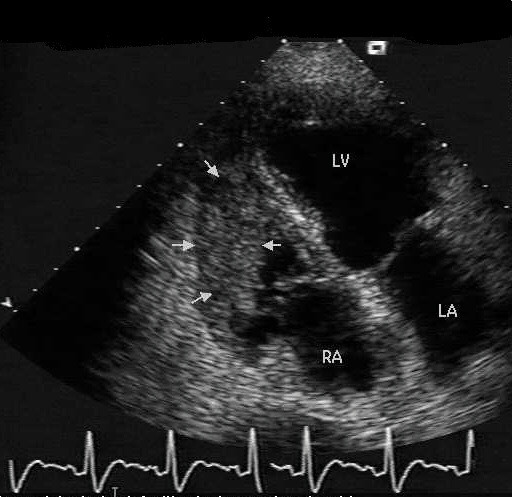

In [28]:
url = "/kaggle/input/roco-dataset/all_data/test/radiology/images/PMC1156959_1477-7819-3-29-2.jpg"

image = Image.open(url)
image

In [29]:
# # prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

transthoracic echocardiography showing a large left atrial myxoma ( arrow ).


In [33]:
import os
import shutil
import pandas as pd
import json
from datasets import load_dataset

# Load and filter test dataset
df_test = pd.read_csv('/kaggle/input/roco-dataset/all_data/test/radiology/testdata.csv', delimiter=',')
df_test

id                                        name  \
0     ROCO_00001            PMC4608653_cro-0008-0385-g01.jpg   
1     ROCO_00006            PMC4840839_ol-11-05-3298-g02.jpg   
2     ROCO_00016  PMC5665693_cureus-0009-00000001639-i01.jpg   
3     ROCO_00025              PMC4813433_EJD-10-188-g001.jpg   
4     ROCO_00031           PMC4252315_PWKI-10-23517-g001.jpg   
...          ...                                         ...   
8174  ROCO_81771      PMC2778768_330_2009_1474_Fig4_HTML.jpg   
8175  ROCO_81778    PMC4802822_12885_2016_2269_Fig2_HTML.jpg   
8176  ROCO_81792               PMC4738497_HV-16-154-g002.jpg   
8177  ROCO_81796     PMC5721517_12876_2017_714_Fig4_HTML.jpg   
8178  ROCO_81798            PMC4063595_OL-08-01-0446-g02.jpg   

                                                caption  
0                           Axial MRI (coronal view).\n  
1      Coronal plain computed tomography image showi...  
2      Axial source image from an intracranial magne...  
3      The apical height, homogeneity, and the thick...  
4             CTO of RCA (closure in the 2nd segment)\n  
...                                                 ...  
8174   Damus–Kaye–Stansel shunt. Oblique coronal MIP...  
8175   MRI pelvis post-radiation, axial STIR/T2W FSE...  
8176   Fluoroscopic image showing attempts to grab t...  
8177   Positron emission tomography–computed tomogra...  
8178   Cholangiography showing the metallic stent pl...  

[8179 rows x 3 columns]

In [35]:
#Create "images" column to create full path for images
df_test['images'] = "/kaggle/input/roco-dataset/all_data/test/radiology/images/" + df_test['name']
df_test.head()

id                                        name  \
0  ROCO_00001            PMC4608653_cro-0008-0385-g01.jpg   
1  ROCO_00006            PMC4840839_ol-11-05-3298-g02.jpg   
2  ROCO_00016  PMC5665693_cureus-0009-00000001639-i01.jpg   
3  ROCO_00025              PMC4813433_EJD-10-188-g001.jpg   
4  ROCO_00031           PMC4252315_PWKI-10-23517-g001.jpg   

                                             caption  \
0                        Axial MRI (coronal view).\n   
1   Coronal plain computed tomography image showi...   
2   Axial source image from an intracranial magne...   
3   The apical height, homogeneity, and the thick...   
4          CTO of RCA (closure in the 2nd segment)\n   

                                              images  
0  /kaggle/input/roco-dataset/all_data/test/radio...  
1  /kaggle/input/roco-dataset/all_data/test/radio...  
2  /kaggle/input/roco-dataset/all_data/test/radio...  
3  /kaggle/input/roco-dataset/all_data/test/radio...  
4  /kaggle/input/roco-dataset/all_data/test/radio...

In [58]:
test_dataset = df_test.copy()

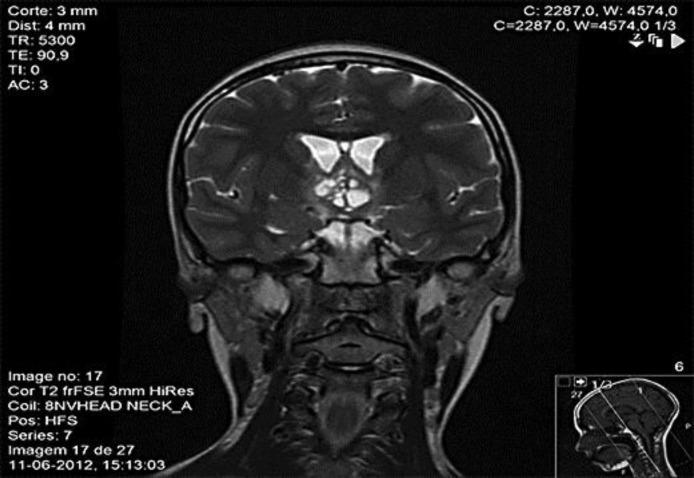

In [60]:
img = Image.open(test_dataset['images'][0])
img

In [74]:
for example in enumerate(df_test):
    print(example['images'])

TypeError: tuple indices must be integers or slices, not str

Average BLEU:  0.03879814252901617


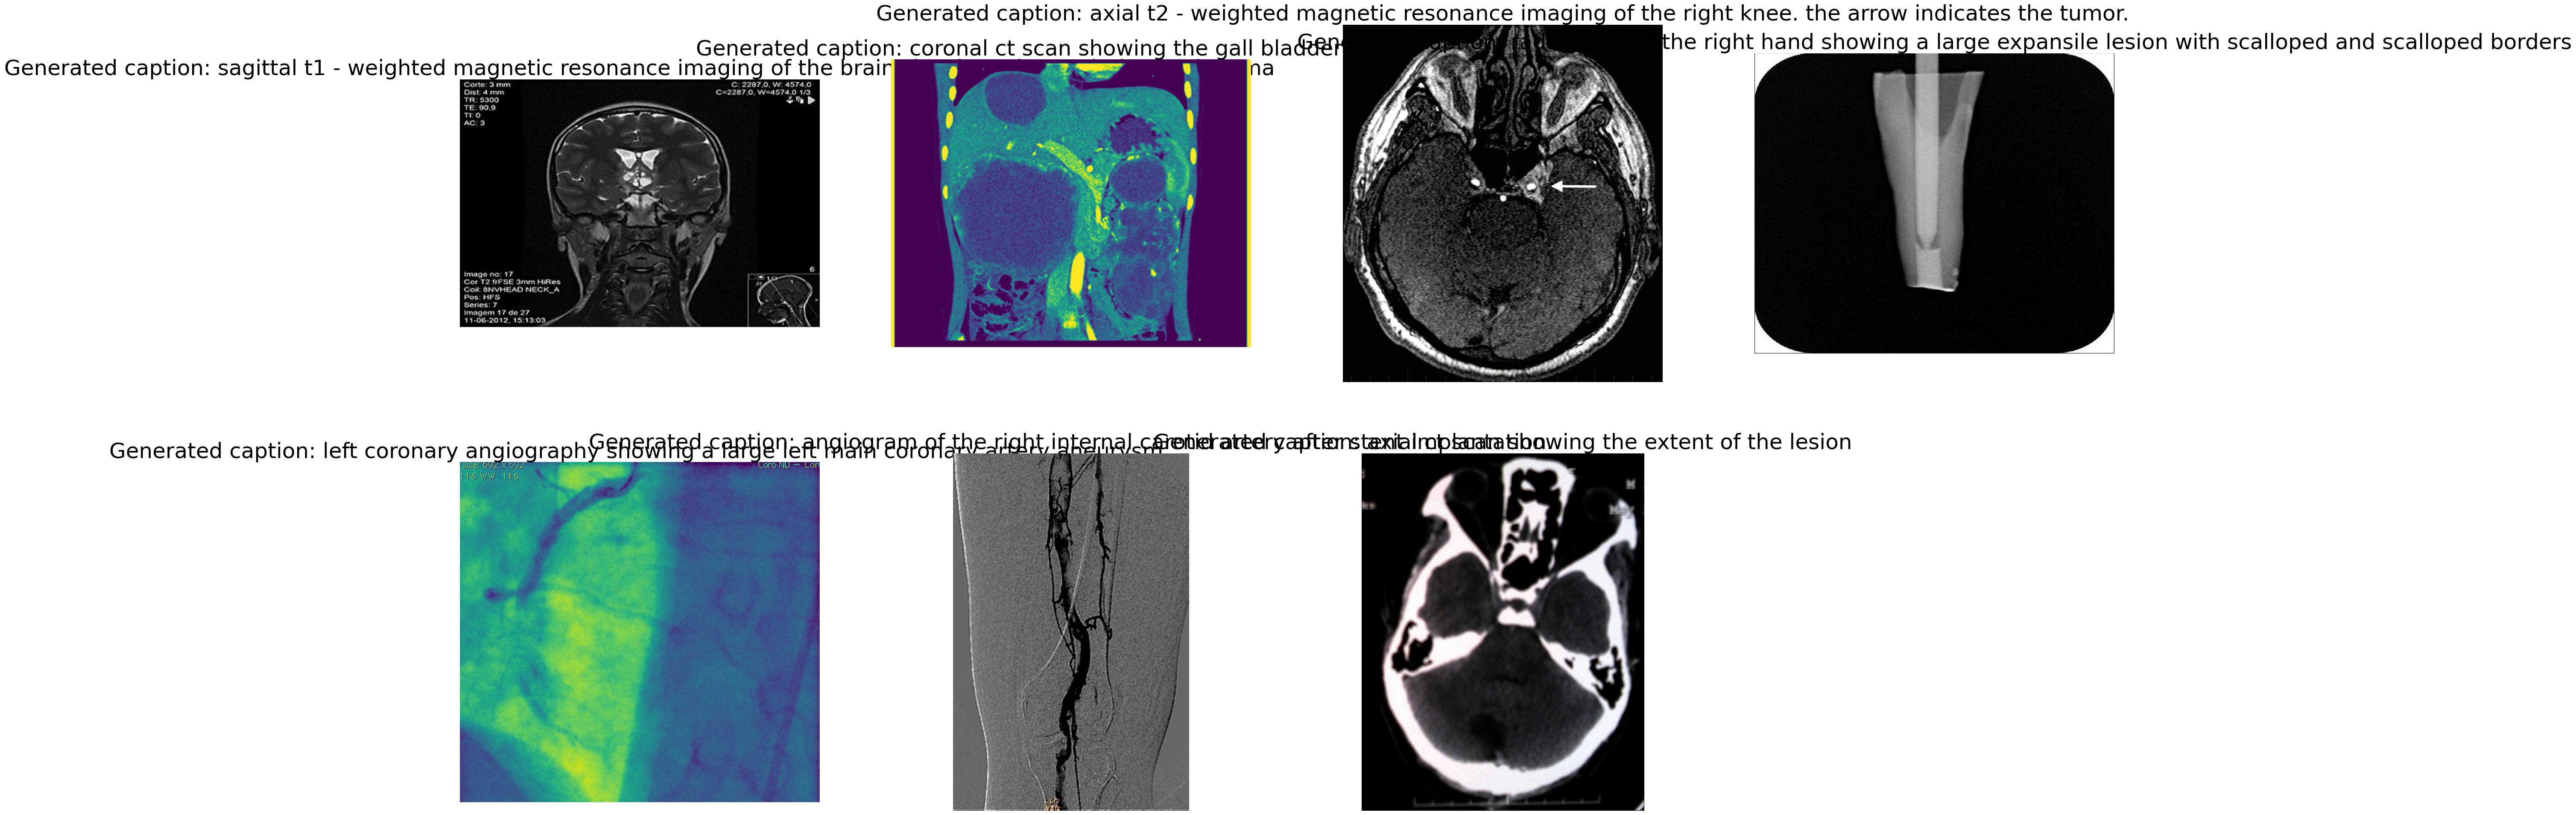

In [83]:
# Predict 16 images of Test Data from trained model
fig = plt.figure(figsize=(50, 50))  # Increase the size of the figure to accommodate 4x4 subplots
average_bleu = 0
n = 6

# Prepare images for the model
for i, example in test_dataset.iterrows():
    image = Image.open(example["images"])
    inputs = processor(images=image, return_tensors="pt").to(device)
    pixel_values = inputs.pixel_values

    # Generate caption
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Add subplot
    fig.add_subplot(4, 4, i+1)  # Change the size of the grid to 4x4
    plt.imshow(image)
    plt.axis("off")

    # Set the title with increased fontsize
    plt.title(f"Generated caption: {generated_caption}", fontsize=36)  # Increase font size

    # BLEU score calculation
    average_bleu += sentence_bleu([example['caption']], generated_caption.split())

    if i == n:  # Display 6 images
        break

# Print average BLEU score
print("Average BLEU: ", average_bleu/n)
plt.show()  # Show the plot after all subplots are added


In [44]:
from huggingface_hub import create_repo,notebook_login

notebook_login()

In [45]:
# Create the repository on Hugging Face Hub
repo_name = "BLIP-Radiology-model"  # Your desired repository name
create_repo(repo_id=f"motheecreator/{repo_name}")

from huggingface_hub import upload_folder

# Upload the model folder to the newly created repository
model_folder = "/kaggle/working/saved_model"
upload_folder(
    folder_path=model_folder,
    repo_id=f"motheecreator/{repo_name}",
    commit_message="Upload BLIP model",
    ignore_patterns=["*.ipynb_checkpoints", "*.DS_Store", "*.git"],
)

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/motheecreator/BLIP-Radiology-model/commit/56fa21aa2d15d51c8ab4bdb7e0b4042265d3f80f', commit_message='Upload BLIP model', commit_description='', oid='56fa21aa2d15d51c8ab4bdb7e0b4042265d3f80f', pr_url=None, repo_url=RepoUrl('https://huggingface.co/motheecreator/BLIP-Radiology-model', endpoint='https://huggingface.co', repo_type='model', repo_id='motheecreator/BLIP-Radiology-model'), pr_revision=None, pr_num=None)

# Deploy Model with Gradio:

In [ ]:
!pip install -q gradio

In [ ]:
import gradio as gr
from PIL import Image

In [ ]:
processor = AutoProcessor.from_pretrained(saved_folder_path)
model = BlipForConditionalGeneration.from_pretrained(saved_folder_path)

In [ ]:
# Define the prediction function
def generate_caption(image):
    # Process the image
    image = Image.fromarray(image)
    #inputs = tokenizer(image, return_tensors="pt")
    inputs = processor(images=image, return_tensors="pt")#.to(device)
    pixel_values = inputs.pixel_values

    # Generate caption
    generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    return generated_caption

In [ ]:
# Define the Gradio interface
interface = gr.Interface(
    fn=generate_caption,
    inputs=gr.Image(),
    outputs=gr.Textbox(),
    live=True
)

In [ ]:
# Launch the Gradio interface
interface.launch()